In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

import tensorflow_hub as hub
import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert


# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [2]:
@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1

config = Config()

In [3]:
def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)
    return text_list


def get_data_from_text_files(folder_name):

    pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text_list_from_files(pos_files)
    neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text_list_from_files(neg_files)
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
        }
    )
    df = df.sample(len(df)).reset_index(drop=True)
    return df


train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

all_data = train_df.append(test_df)

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )


def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """Build Text vectorization layer

    Args:
      texts (list): List of string i.e input texts
      vocab_size (int): vocab size
      max_seq (int): Maximum sequence lenght.
      special_tokens (list, optional): List of special tokens. Defaults to ['[MASK]'].

    Returns:
        layers.Layer: Return TextVectorization Keras Layer
    """
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert mask token in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    # 0 PAD 1 UNK 100 CLS 101 SEP 102 MASK
#     vocab = vocab + ['tmp']
#     vocab[101:-1] = vocab[100:-2]
#     vocab[100] = "[mask]"
#     vocab = vocab[2 : vocab_size - len(special_tokens)]
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer


vectorize_layer = get_vectorize_layer(
    all_data.review.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Get mask token id for masked language model
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]


In [ ]:
def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()


def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights


# We have 25000 examples for training
x_train = encode(train_df.review.values)  # encode reviews with vectorizer
y_train = train_df.sentiment.values
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# We have 25000 examples for testing
x_test = encode(test_df.review.values)
y_test = test_df.sentiment.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)

# Build dataset for end to end model input (will be used at the end)
test_raw_classifier_ds = tf.data.Dataset.from_tensor_slices(
    (test_df.review.values, y_test)
).batch(config.BATCH_SIZE)

# Prepare data for masked language model
x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

In [ ]:
def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc


loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
loss_tracker = tf.keras.metrics.Mean(name="loss")

In [ ]:
class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)

    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    position_embeddings = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings

    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    
    
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}

In [ ]:
class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)


sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

In [4]:
config_dict = {'attention_probs_dropout_prob': 0.01, 
               'hidden_act': 'gelu', 
               'hidden_dropout_prob': 0.1, 
               'hidden_size': 768, 
               'initializer_range': 0.02, 
               'intermediate_size': 3072, 
               'max_position_embeddings': 128, 
               'num_attention_heads': 12, 
               'num_hidden_layers': 12, 
               'type_vocab_size': 2, 
               'vocab_size': 22001}

bert_config = bert.configs.BertConfig.from_dict(config_dict)

In [5]:
keras_model, transformer_encoder, pretrainer_model = bert.bert_models.pretrain_model(
    bert_config, seq_length=128, max_predictions_per_seq=2, use_next_sentence_label=False, return_core_pretrainer_model=True)

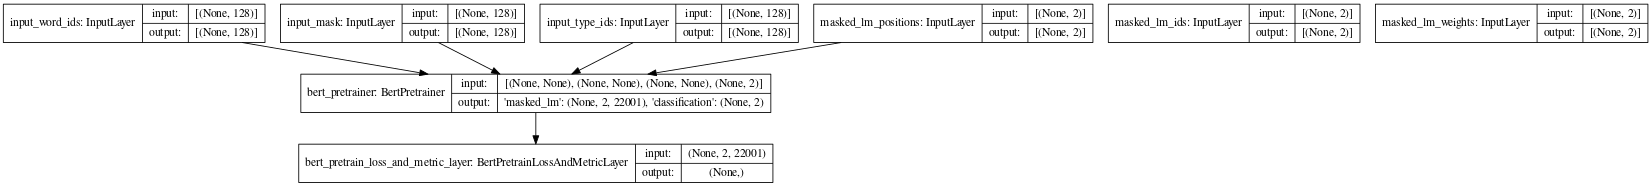

In [8]:
tf.keras.utils.plot_model(keras_model, show_shapes=True, dpi=60)

In [ ]:
# Set up epochs and steps
epochs = 1
batch_size = 128
eval_batch_size = 128

train_data_size = len(tc_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [5]:
import tensorflow_text as tf_text
tf_text.mask_language_model(
    input_ids, item_selector, mask_values_chooser, axis=1
)

NameError: name 'input_ids' is not defined